In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms

from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

## Helper Functions

The following cells contain functions used throughout the course of the question, they include model class creation, Glorot Initialization, Standardization of inputs and a function for creating data loaders for use during Pytorch training

In [2]:
#Initializes using Glorot Initialization
def GlorotInitialize(model):
    #Initialize parameters
    params = list(model.parameters())

    for p in params:
        if len(p.size()) > 1:
            dl = np.sqrt(6.0/(p.size()[0]+p.size()[1]))
            nn.init.uniform(p,-dl,dl)
        else:
            nn.init.uniform(p,0,0)
            
    return model

class MLP_20(nn.Module):
    
    def __init__(self,insize,outsize):
        super(MLP_20,self).__init__()
        self.fc1 = nn.Linear(insize,100)
        self.fc2 = nn.Linear(100,outsize)
        self.insize = insize
        
    def forward(self,x):
        a1 = self.fc1(x)
        h1 = nn.functional.relu(a1)
        
        logits = self.fc2(h1)
        
        return logits
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices

In [3]:
def restructure_data(data):
    samples, vocab_size, max_word_count = np.max(data,axis=0)
    restructured_data = np.zeros((int(samples),int(vocab_size)))
    for i in range(len(data)):
        if (data[i,1]-1)<=vocab_size:
            restructured_data[int(data[i,0]-1),int(data[i,1]-1)]=data[i,2]
    return restructured_data

def tfidf(data):
    idf =  np.log(np.divide((data.shape[0]*np.ones_like(data)),1+np.sum(np.equal(data>0,1),axis=0)[None,:].astype(np.float)))
    return np.multiply(data,idf)

def make_loaders(data,labels,val_split,test_data=None,test_labels=None,batch_size=128):
    val_loader = 0
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    split = int((1-val_split)*indices.shape[0])
    train_data, val_data = data[indices[:split],:], data[indices[split:],:]
    train_labels, val_labels = labels[indices[:split]], labels[indices[split:]]
    del indices
    print train_data.shape, train_labels.shape
    print val_data.shape, val_labels.shape
    
    train_tensor = torch.utils.data.TensorDataset(torch.Tensor(train_data),torch.IntTensor(train_labels))
    del train_data
    del train_labels
    train_loader = torch.utils.data.DataLoader(train_tensor,batch_size=batch_size, shuffle = True)
    del train_tensor
    if val_split<1:
        val_tensor = torch.utils.data.TensorDataset(torch.Tensor(val_data), torch.IntTensor(val_labels))
        del val_data
        del val_labels
        val_loader = torch.utils.data.DataLoader(val_tensor,batch_size=batch_size, shuffle = True)
        del val_tensor
        
    if (type(test_data) != type(None)):
        test_tensor = torch.utils.data.TensorDataset(torch.Tensor(test_data),torch.IntTensor(test_labels))
        test_loader = torch.utils.data.DataLoader(test_tensor,batch_size=batch_size, shuffle = True)
        return train_loader, val_loader, test_loader

    return train_loader, val_loader


def standardize_data(data):
    #standardized_data = np.divide(data - np.mean(data,axis=0)[None,:],np.var(data,axis=0)+1e-5)
    s = StandardScaler()
    s.fit(data)
    s.var_ += 1e-5
    standardized_data = s.transform(data)
    return standardized_data

In [4]:
def train(model, num_epochs,trainLoader,optimizer,valLoader=None, testLoader = None, verbose=True):
    bestValAcc = 0
    bestNetwork = 0
    train_accuracy = []
    val_accuracy = []
    test_accuracy = []
    epoch_loss=[0]*num_epochs
    loss_crit = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        losses = []
        correct = 0
        total = 0
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        model.train()
        for batch_index, (inputs, targets) in enumerate(trainLoader):
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
            _, preds = model.prediction(logits)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
            loss = loss_crit(logits,targets)

            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
        epoch_loss[epoch] = np.mean(losses)
        train_accuracy.append(correct/float(total))
        
        if (valLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(valLoader):
                x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                val_correct += preds.eq(targets.data).sum()
                val_total += targets.size(0)
            val_acc = (val_correct/float(val_total))
            val_accuracy.append(val_acc)
                            
            if val_acc > bestValAcc:
                bestNetwork = model
                bestValAcc= val_acc
                
                
        if (testLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(testLoader):
                x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                test_correct += preds.eq(targets.data).sum()
                test_total += targets.size(0)
            test_acc = (test_correct/float(test_total))
            test_accuracy.append(test_acc)
            
        if (valLoader != None and testLoader != None and verbose == True):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
        elif (valLoader != None and testLoader == None and verbose == True):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
        elif (verbose == True):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
    return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy)

In [5]:
def train_5000(model,train_loader,optimizer,loss_func, verbose= True):
    losses = [0]*5000
    batch_number = 0
    model = GlorotInitialize(model)
    for i in range(1000):
        for batch_index, (inputs, targets) in enumerate(train_loader):
            
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
            loss = loss_func(logits,targets)
            
            loss.backward()
            optimizer.step()
            losses[batch_number] = (loss.data[0])
            if (verbose or batch_number%500==0):
                print "Iteration: " + repr(batch_number + 1) + " Loss: " + repr(loss.data[0])
            batch_number += 1
            if batch_number == 5000:
                plt.plot(losses, label='Train losses')
                plt.legend()
                plt.show()
                return model,losses

In [6]:
VocabSize = 51000
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

### 2.A Building the Model

Here we will test different preprocessing methods on the data set. First we'll explore basic word counts, then tf-idf preprocessing and finally standardization of inputs

#### 2.A No preprocessing

In [7]:
countVect = CountVectorizer(max_features=VocabSize, stop_words='english')
countVect.fit(newsgroups_train.data)

count_train = countVect.transform(newsgroups_train.data)
count_test = countVect.transform(newsgroups_test.data)

count_train = count_train.todense()
count_test = count_test.todense()

train_labels = newsgroups_train.target
test_labels = newsgroups_test.target

In [8]:
train_loader_ng_count,val_loader_ng_count, test_loader_ng_count = make_loaders(count_train,train_labels,
                                                                         0.2,count_test,test_labels)

(9051, 51000) (9051,)
(2263, 51000) (2263,)


##### Hyperparameter search for no preprocessing

Learning rate: 0.01
Epoch : 1 Loss : 47.377  Train Accuracy: 0.316 Validation Accuracy: 0.228 Test Accuracy: 0.207
Epoch : 2 Loss : 353.519  Train Accuracy: 0.124 Validation Accuracy: 0.079 Test Accuracy: 0.068
Epoch : 3 Loss : 340.187  Train Accuracy: 0.088 Validation Accuracy: 0.077 Test Accuracy: 0.072
Epoch : 4 Loss : 1743.436  Train Accuracy: 0.087 Validation Accuracy: 0.081 Test Accuracy: 0.070
Epoch : 5 Loss : 10004.566  Train Accuracy: 0.079 Validation Accuracy: 0.079 Test Accuracy: 0.066
Epoch : 6 Loss : 72558.662  Train Accuracy: 0.073 Validation Accuracy: 0.064 Test Accuracy: 0.062
Epoch : 7 Loss : 28814.470  Train Accuracy: 0.079 Validation Accuracy: 0.062 Test Accuracy: 0.054
Epoch : 8 Loss : 597.181  Train Accuracy: 0.067 Validation Accuracy: 0.072 Test Accuracy: 0.064
Epoch : 9 Loss : 2858.498  Train Accuracy: 0.067 Validation Accuracy: 0.065 Test Accuracy: 0.063
Epoch : 10 Loss : 211.942  Train Accuracy: 0.069 Validation Accuracy: 0.061 Test Accuracy: 0.061
Epoch : 11 L

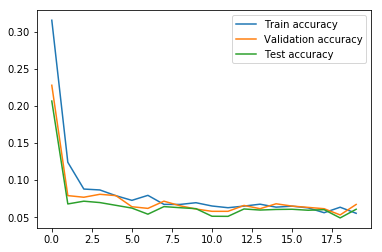

Learning rate: 0.001
Epoch : 1 Loss : 2.347  Train Accuracy: 0.402 Validation Accuracy: 0.505 Test Accuracy: 0.440
Epoch : 2 Loss : 57.607  Train Accuracy: 0.425 Validation Accuracy: 0.381 Test Accuracy: 0.334
Epoch : 3 Loss : 18.788  Train Accuracy: 0.373 Validation Accuracy: 0.290 Test Accuracy: 0.235
Epoch : 4 Loss : 16.184  Train Accuracy: 0.273 Validation Accuracy: 0.270 Test Accuracy: 0.217
Epoch : 5 Loss : 10.676  Train Accuracy: 0.257 Validation Accuracy: 0.217 Test Accuracy: 0.182
Epoch : 6 Loss : 12.235  Train Accuracy: 0.241 Validation Accuracy: 0.232 Test Accuracy: 0.188
Epoch : 7 Loss : 10.341  Train Accuracy: 0.240 Validation Accuracy: 0.222 Test Accuracy: 0.168
Epoch : 8 Loss : 12.910  Train Accuracy: 0.248 Validation Accuracy: 0.234 Test Accuracy: 0.191
Epoch : 9 Loss : 13.500  Train Accuracy: 0.255 Validation Accuracy: 0.240 Test Accuracy: 0.197
Epoch : 10 Loss : 14.043  Train Accuracy: 0.245 Validation Accuracy: 0.214 Test Accuracy: 0.178
Epoch : 11 Loss : 14.173  Tra

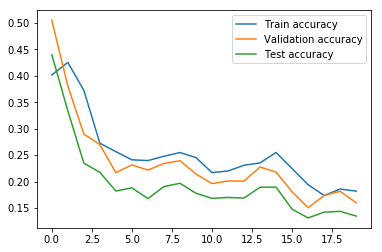

Learning rate: 0.0001
Epoch : 1 Loss : 2.871  Train Accuracy: 0.224 Validation Accuracy: 0.492 Test Accuracy: 0.438
Epoch : 2 Loss : 1.992  Train Accuracy: 0.593 Validation Accuracy: 0.673 Test Accuracy: 0.584
Epoch : 3 Loss : 1.165  Train Accuracy: 0.724 Validation Accuracy: 0.687 Test Accuracy: 0.613
Epoch : 4 Loss : 1.266  Train Accuracy: 0.700 Validation Accuracy: 0.608 Test Accuracy: 0.531
Epoch : 5 Loss : 20.597  Train Accuracy: 0.500 Validation Accuracy: 0.517 Test Accuracy: 0.456
Epoch : 6 Loss : 23.754  Train Accuracy: 0.404 Validation Accuracy: 0.300 Test Accuracy: 0.261
Epoch : 7 Loss : 3.860  Train Accuracy: 0.482 Validation Accuracy: 0.439 Test Accuracy: 0.377
Epoch : 8 Loss : 1.954  Train Accuracy: 0.492 Validation Accuracy: 0.477 Test Accuracy: 0.390
Epoch : 9 Loss : 1.748  Train Accuracy: 0.570 Validation Accuracy: 0.537 Test Accuracy: 0.470
Epoch : 10 Loss : 1.879  Train Accuracy: 0.546 Validation Accuracy: 0.500 Test Accuracy: 0.434
Epoch : 11 Loss : 1.515  Train Accu

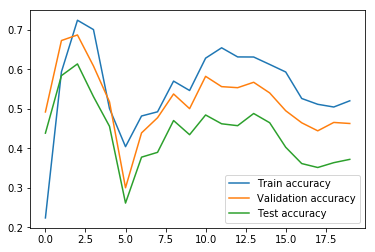

Learning rate: 1e-05
Epoch : 1 Loss : 3.011  Train Accuracy: 0.055 Validation Accuracy: 0.118 Test Accuracy: 0.089
Epoch : 2 Loss : 2.878  Train Accuracy: 0.253 Validation Accuracy: 0.400 Test Accuracy: 0.342
Epoch : 3 Loss : 2.646  Train Accuracy: 0.520 Validation Accuracy: 0.571 Test Accuracy: 0.512
Epoch : 4 Loss : 2.291  Train Accuracy: 0.639 Validation Accuracy: 0.635 Test Accuracy: 0.567
Epoch : 5 Loss : 1.905  Train Accuracy: 0.688 Validation Accuracy: 0.684 Test Accuracy: 0.603
Epoch : 6 Loss : 1.532  Train Accuracy: 0.738 Validation Accuracy: 0.712 Test Accuracy: 0.622
Epoch : 7 Loss : 1.238  Train Accuracy: 0.761 Validation Accuracy: 0.703 Test Accuracy: 0.606
Epoch : 8 Loss : 1.012  Train Accuracy: 0.767 Validation Accuracy: 0.745 Test Accuracy: 0.654
Epoch : 9 Loss : 0.821  Train Accuracy: 0.818 Validation Accuracy: 0.776 Test Accuracy: 0.698
Epoch : 10 Loss : 0.713  Train Accuracy: 0.825 Validation Accuracy: 0.788 Test Accuracy: 0.704
Epoch : 11 Loss : 0.637  Train Accurac

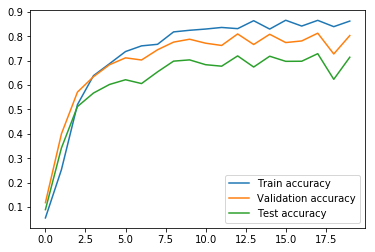

Learning rate: 1e-06
Epoch : 1 Loss : 3.020  Train Accuracy: 0.056 Validation Accuracy: 0.058 Test Accuracy: 0.058
Epoch : 2 Loss : 2.990  Train Accuracy: 0.068 Validation Accuracy: 0.079 Test Accuracy: 0.074
Epoch : 3 Loss : 2.962  Train Accuracy: 0.103 Validation Accuracy: 0.128 Test Accuracy: 0.110
Epoch : 4 Loss : 2.924  Train Accuracy: 0.169 Validation Accuracy: 0.188 Test Accuracy: 0.163
Epoch : 5 Loss : 2.878  Train Accuracy: 0.248 Validation Accuracy: 0.271 Test Accuracy: 0.228
Epoch : 6 Loss : 2.820  Train Accuracy: 0.326 Validation Accuracy: 0.332 Test Accuracy: 0.291
Epoch : 7 Loss : 2.748  Train Accuracy: 0.398 Validation Accuracy: 0.391 Test Accuracy: 0.343
Epoch : 8 Loss : 2.659  Train Accuracy: 0.453 Validation Accuracy: 0.442 Test Accuracy: 0.392
Epoch : 9 Loss : 2.553  Train Accuracy: 0.510 Validation Accuracy: 0.499 Test Accuracy: 0.437
Epoch : 10 Loss : 2.434  Train Accuracy: 0.562 Validation Accuracy: 0.545 Test Accuracy: 0.486
Epoch : 11 Loss : 2.308  Train Accurac

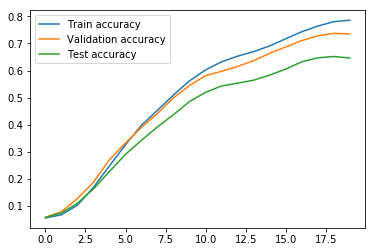

In [10]:
lrs = [1e-2,1e-3,1e-4,1e-5,1e-6]
models = [0]*len(lrs)
train_results = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models[i] = MLP_20(VocabSize,20)
    models[i] = GlorotInitialize(models[i])
    optimizer = torch.optim.SGD(models[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results[i] = train(models[i],20,train_loader_ng_count,optimizer,val_loader_ng_count,
                             test_loader_ng_count)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

#### 2.A TF-IDF Preprocessing

In [7]:
tfidfVect = TfidfVectorizer(max_features=VocabSize,stop_words='english')
tfidfVect.fit(newsgroups_train.data)

tfidf_train = tfidfVect.transform(newsgroups_train.data)
tfidf_test = tfidfVect.transform(newsgroups_test.data)


tfidf_train = tfidf_train.todense()
tfidf_test = tfidf_test.todense()
train_labels = newsgroups_train.target
test_labels = newsgroups_test.target

In [8]:
train_loader_ng_tfidf,val_loader_ng_tfidf, test_loader_ng_tfidf = make_loaders(tfidf_train,train_labels,
                                                                         0.2,tfidf_test,test_labels)

(9051, 51000) (9051,)
(2263, 51000) (2263,)


##### Hyperparameter search for TFIDF preprocessing

Learning rate: 0.01
Epoch : 1 Loss : 2.992  Train Accuracy: 0.066 Validation Accuracy: 0.057 Test Accuracy: 0.054
Epoch : 2 Loss : 3.605  Train Accuracy: 0.096 Validation Accuracy: 0.118 Test Accuracy: 0.104
Epoch : 3 Loss : 4.586  Train Accuracy: 0.080 Validation Accuracy: 0.042 Test Accuracy: 0.041
Epoch : 4 Loss : 5.562  Train Accuracy: 0.060 Validation Accuracy: 0.057 Test Accuracy: 0.052
Epoch : 5 Loss : 6.784  Train Accuracy: 0.048 Validation Accuracy: 0.063 Test Accuracy: 0.053
Epoch : 6 Loss : 14.969  Train Accuracy: 0.051 Validation Accuracy: 0.049 Test Accuracy: 0.052
Epoch : 7 Loss : 28.451  Train Accuracy: 0.053 Validation Accuracy: 0.043 Test Accuracy: 0.048
Epoch : 8 Loss : 41.839  Train Accuracy: 0.052 Validation Accuracy: 0.047 Test Accuracy: 0.052
Epoch : 9 Loss : 61.752  Train Accuracy: 0.049 Validation Accuracy: 0.052 Test Accuracy: 0.053
Epoch : 10 Loss : 76.081  Train Accuracy: 0.056 Validation Accuracy: 0.055 Test Accuracy: 0.053
Epoch : 11 Loss : 91.089  Train Ac

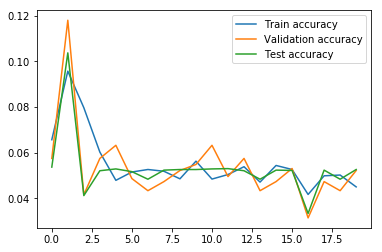

Learning rate: 0.001
Epoch : 1 Loss : 2.990  Train Accuracy: 0.063 Validation Accuracy: 0.068 Test Accuracy: 0.065
Epoch : 2 Loss : 2.951  Train Accuracy: 0.131 Validation Accuracy: 0.171 Test Accuracy: 0.148
Epoch : 3 Loss : 2.837  Train Accuracy: 0.349 Validation Accuracy: 0.407 Test Accuracy: 0.349
Epoch : 4 Loss : 2.577  Train Accuracy: 0.332 Validation Accuracy: 0.375 Test Accuracy: 0.338
Epoch : 5 Loss : 2.300  Train Accuracy: 0.361 Validation Accuracy: 0.251 Test Accuracy: 0.224
Epoch : 6 Loss : 2.668  Train Accuracy: 0.342 Validation Accuracy: 0.221 Test Accuracy: 0.183
Epoch : 7 Loss : 4.927  Train Accuracy: 0.189 Validation Accuracy: 0.194 Test Accuracy: 0.181
Epoch : 8 Loss : 5.464  Train Accuracy: 0.083 Validation Accuracy: 0.052 Test Accuracy: 0.057
Epoch : 9 Loss : 4.531  Train Accuracy: 0.075 Validation Accuracy: 0.051 Test Accuracy: 0.050
Epoch : 10 Loss : 5.018  Train Accuracy: 0.062 Validation Accuracy: 0.055 Test Accuracy: 0.052
Epoch : 11 Loss : 5.471  Train Accurac

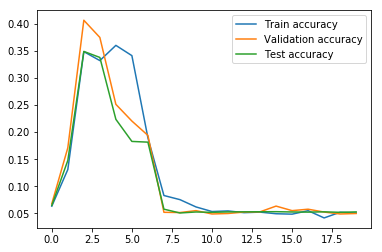

Learning rate: 0.0001
Epoch : 1 Loss : 2.995  Train Accuracy: 0.063 Validation Accuracy: 0.073 Test Accuracy: 0.067
Epoch : 2 Loss : 2.990  Train Accuracy: 0.086 Validation Accuracy: 0.092 Test Accuracy: 0.090
Epoch : 3 Loss : 2.980  Train Accuracy: 0.098 Validation Accuracy: 0.089 Test Accuracy: 0.083
Epoch : 4 Loss : 2.966  Train Accuracy: 0.103 Validation Accuracy: 0.098 Test Accuracy: 0.097
Epoch : 5 Loss : 2.947  Train Accuracy: 0.140 Validation Accuracy: 0.175 Test Accuracy: 0.159
Epoch : 6 Loss : 2.919  Train Accuracy: 0.368 Validation Accuracy: 0.441 Test Accuracy: 0.417
Epoch : 7 Loss : 2.878  Train Accuracy: 0.553 Validation Accuracy: 0.562 Test Accuracy: 0.525
Epoch : 8 Loss : 2.824  Train Accuracy: 0.698 Validation Accuracy: 0.632 Test Accuracy: 0.568
Epoch : 9 Loss : 2.753  Train Accuracy: 0.662 Validation Accuracy: 0.612 Test Accuracy: 0.548
Epoch : 10 Loss : 2.651  Train Accuracy: 0.723 Validation Accuracy: 0.667 Test Accuracy: 0.623
Epoch : 11 Loss : 2.506  Train Accura

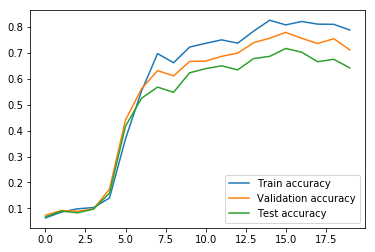

Learning rate: 1e-05
Epoch : 1 Loss : 2.996  Train Accuracy: 0.043 Validation Accuracy: 0.039 Test Accuracy: 0.044
Epoch : 2 Loss : 2.995  Train Accuracy: 0.053 Validation Accuracy: 0.049 Test Accuracy: 0.056
Epoch : 3 Loss : 2.994  Train Accuracy: 0.066 Validation Accuracy: 0.056 Test Accuracy: 0.066
Epoch : 4 Loss : 2.992  Train Accuracy: 0.069 Validation Accuracy: 0.057 Test Accuracy: 0.063
Epoch : 5 Loss : 2.990  Train Accuracy: 0.068 Validation Accuracy: 0.056 Test Accuracy: 0.061
Epoch : 6 Loss : 2.987  Train Accuracy: 0.062 Validation Accuracy: 0.054 Test Accuracy: 0.058
Epoch : 7 Loss : 2.985  Train Accuracy: 0.062 Validation Accuracy: 0.054 Test Accuracy: 0.058
Epoch : 8 Loss : 2.981  Train Accuracy: 0.065 Validation Accuracy: 0.057 Test Accuracy: 0.063
Epoch : 9 Loss : 2.978  Train Accuracy: 0.073 Validation Accuracy: 0.063 Test Accuracy: 0.068
Epoch : 10 Loss : 2.974  Train Accuracy: 0.078 Validation Accuracy: 0.065 Test Accuracy: 0.071
Epoch : 11 Loss : 2.970  Train Accurac

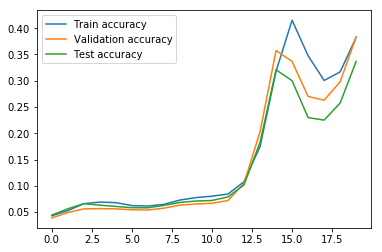

In [9]:
lrs = [1e-2,1e-3,1e-4,1e-5]
models = [0]*len(lrs)
train_results = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models[i] = MLP_20(VocabSize,20)
    models[i] = GlorotInitialize(models[i])
    optimizer = torch.optim.SGD(models[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results[i] = train(models[i],20,train_loader_ng_tfidf,optimizer,val_loader_ng_tfidf, test_loader_ng_tfidf)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

#### 2.A Standardization of input features

In [7]:
countVect = CountVectorizer(max_features=VocabSize, stop_words='english')
countVect.fit(newsgroups_train.data)

stand_train = countVect.transform(newsgroups_train.data)
stand_test = countVect.transform(newsgroups_test.data)

stand_train = stand_train.todense()
stand_test = stand_test.todense()

stand_train = standardize_data(stand_train)
stand_test = standardize_data(stand_test)

train_labels = newsgroups_train.target
test_labels = newsgroups_test.target

/home/kyle/Downloads/yes/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
print stand_train.s

In [8]:
train_loader_ng_stand, val_loader_ng_stand, test_loader_ng_stand = make_loaders(stand_train,train_labels,0.2,stand_test,test_labels)

(9051, 51000) (9051,)
(2263, 51000) (2263,)


##### Hyperparameter search for Standardized features preprocessing

Learning rate: 0.01
Epoch : 1 Loss : 2508.426  Train Accuracy: 0.489 Validation Accuracy: 0.446 Test Accuracy: 0.371
Epoch : 2 Loss : 1477764756.260  Train Accuracy: 0.526 Validation Accuracy: 0.334 Test Accuracy: 0.317
Epoch : 3 Loss : 697462925467071.125  Train Accuracy: 0.556 Validation Accuracy: 0.599 Test Accuracy: 0.511
Epoch : 4 Loss : 5494902209387048206336.000  Train Accuracy: 0.471 Validation Accuracy: 0.334 Test Accuracy: 0.387
Epoch : 5 Loss : 8231329477847069953395523584.000  Train Accuracy: 0.461 Validation Accuracy: 0.424 Test Accuracy: 0.399
Epoch : 6 Loss : 17472546091048025404063289916260352.000  Train Accuracy: 0.510 Validation Accuracy: 0.457 Test Accuracy: 0.443
Epoch : 7 Loss : nan  Train Accuracy: 0.185 Validation Accuracy: 0.046 Test Accuracy: 0.042
Epoch : 8 Loss : nan  Train Accuracy: 0.042 Validation Accuracy: 0.046 Test Accuracy: 0.042
Epoch : 9 Loss : nan  Train Accuracy: 0.042 Validation Accuracy: 0.046 Test Accuracy: 0.042
Epoch : 10 Loss : nan  Train Acc

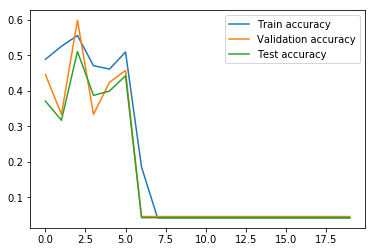

Learning rate: 0.001
Epoch : 1 Loss : 2.290  Train Accuracy: 0.580 Validation Accuracy: 0.722 Test Accuracy: 0.601
Epoch : 2 Loss : 35.570  Train Accuracy: 0.790 Validation Accuracy: 0.683 Test Accuracy: 0.582
Epoch : 3 Loss : 735.918  Train Accuracy: 0.869 Validation Accuracy: 0.711 Test Accuracy: 0.554
Epoch : 4 Loss : 33070.972  Train Accuracy: 0.790 Validation Accuracy: 0.550 Test Accuracy: 0.404
Epoch : 5 Loss : 2988548.916  Train Accuracy: 0.679 Validation Accuracy: 0.601 Test Accuracy: 0.555
Epoch : 6 Loss : 328425235.134  Train Accuracy: 0.653 Validation Accuracy: 0.670 Test Accuracy: 0.625
Epoch : 7 Loss : 6901458097.577  Train Accuracy: 0.783 Validation Accuracy: 0.734 Test Accuracy: 0.631
Epoch : 8 Loss : 158460328224.451  Train Accuracy: 0.813 Validation Accuracy: 0.684 Test Accuracy: 0.602
Epoch : 9 Loss : 15522610781631.098  Train Accuracy: 0.758 Validation Accuracy: 0.742 Test Accuracy: 0.625
Epoch : 10 Loss : 395351490515694.000  Train Accuracy: 0.764 Validation Accurac

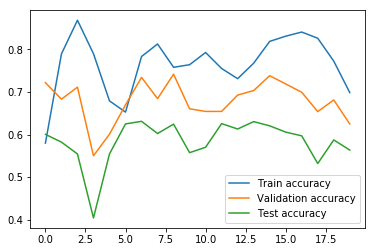

Learning rate: 0.0001
Epoch : 1 Loss : 2.230  Train Accuracy: 0.413 Validation Accuracy: 0.787 Test Accuracy: 0.689
Epoch : 2 Loss : 0.191  Train Accuracy: 0.963 Validation Accuracy: 0.834 Test Accuracy: 0.708
Epoch : 3 Loss : 0.081  Train Accuracy: 0.988 Validation Accuracy: 0.850 Test Accuracy: 0.746
Epoch : 4 Loss : 0.106  Train Accuracy: 0.988 Validation Accuracy: 0.862 Test Accuracy: 0.753
Epoch : 5 Loss : 0.404  Train Accuracy: 0.983 Validation Accuracy: 0.856 Test Accuracy: 0.738
Epoch : 6 Loss : 0.363  Train Accuracy: 0.977 Validation Accuracy: 0.823 Test Accuracy: 0.699
Epoch : 7 Loss : 0.500  Train Accuracy: 0.979 Validation Accuracy: 0.838 Test Accuracy: 0.698
Epoch : 8 Loss : 0.679  Train Accuracy: 0.984 Validation Accuracy: 0.851 Test Accuracy: 0.734
Epoch : 9 Loss : 0.616  Train Accuracy: 0.994 Validation Accuracy: 0.865 Test Accuracy: 0.741
Epoch : 10 Loss : 1.037  Train Accuracy: 0.989 Validation Accuracy: 0.870 Test Accuracy: 0.748
Epoch : 11 Loss : 1.185  Train Accura

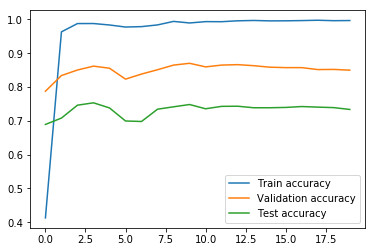

Learning rate: 1e-05
Epoch : 1 Loss : 3.388  Train Accuracy: 0.086 Validation Accuracy: 0.209 Test Accuracy: 0.164
Epoch : 2 Loss : 1.347  Train Accuracy: 0.734 Validation Accuracy: 0.706 Test Accuracy: 0.591
Epoch : 3 Loss : 0.390  Train Accuracy: 0.965 Validation Accuracy: 0.801 Test Accuracy: 0.687
Epoch : 4 Loss : 0.158  Train Accuracy: 0.978 Validation Accuracy: 0.821 Test Accuracy: 0.693
Epoch : 5 Loss : 0.091  Train Accuracy: 0.981 Validation Accuracy: 0.821 Test Accuracy: 0.696
Epoch : 6 Loss : 0.059  Train Accuracy: 0.987 Validation Accuracy: 0.835 Test Accuracy: 0.700
Epoch : 7 Loss : 0.038  Train Accuracy: 0.991 Validation Accuracy: 0.847 Test Accuracy: 0.712
Epoch : 8 Loss : 0.027  Train Accuracy: 0.994 Validation Accuracy: 0.852 Test Accuracy: 0.727
Epoch : 9 Loss : 0.018  Train Accuracy: 0.996 Validation Accuracy: 0.862 Test Accuracy: 0.739
Epoch : 10 Loss : 0.013  Train Accuracy: 0.996 Validation Accuracy: 0.865 Test Accuracy: 0.749
Epoch : 11 Loss : 0.011  Train Accurac

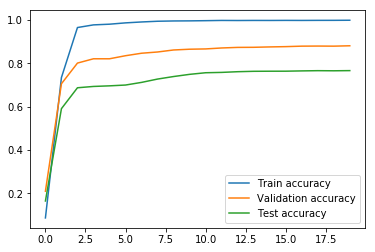

Learning rate: 1e-06
Epoch : 1 Loss : 3.740  Train Accuracy: 0.050 Validation Accuracy: 0.051 Test Accuracy: 0.052
Epoch : 2 Loss : 3.268  Train Accuracy: 0.087 Validation Accuracy: 0.090 Test Accuracy: 0.080
Epoch : 3 Loss : 2.571  Train Accuracy: 0.236 Validation Accuracy: 0.208 Test Accuracy: 0.170
Epoch : 4 Loss : 1.852  Train Accuracy: 0.522 Validation Accuracy: 0.399 Test Accuracy: 0.317
Epoch : 5 Loss : 1.261  Train Accuracy: 0.778 Validation Accuracy: 0.576 Test Accuracy: 0.470
Epoch : 6 Loss : 0.837  Train Accuracy: 0.907 Validation Accuracy: 0.677 Test Accuracy: 0.572
Epoch : 7 Loss : 0.565  Train Accuracy: 0.955 Validation Accuracy: 0.734 Test Accuracy: 0.631
Epoch : 8 Loss : 0.389  Train Accuracy: 0.972 Validation Accuracy: 0.776 Test Accuracy: 0.668
Epoch : 9 Loss : 0.279  Train Accuracy: 0.978 Validation Accuracy: 0.795 Test Accuracy: 0.687
Epoch : 10 Loss : 0.210  Train Accuracy: 0.981 Validation Accuracy: 0.809 Test Accuracy: 0.699
Epoch : 11 Loss : 0.168  Train Accurac

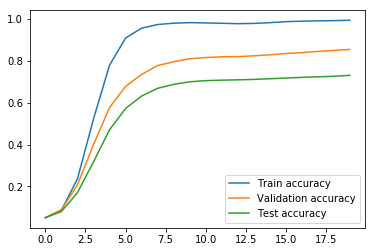

In [9]:
lrs = [1e-2,1e-3,1e-4,1e-5,1e-6]
models = [0]*len(lrs)
train_results = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models[i] = MLP_20(VocabSize,20)
    models[i] = GlorotInitialize(models[i])
    optimizer = torch.optim.SGD(models[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results[i] = train(models[i],20,train_loader_ng_stand,optimizer,val_loader_ng_stand, test_loader_ng_stand)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

### 2.A.1

Without preprocessing the model had an optimal validation result with a learning rate of 1e-5. However, it should be noted that a learning rate of 1e-6 is substantially smoother and does not have the loss over an epoch increase. The best validation accuracy is seen to be 80.9%. However, one would expect better convergance using a learning rate of 1e-6 and more training time.

TF-IDF preprocessing has an optimal validation result with a learning rate of 1e-4, with an accuracy of 77.9%.  Moreover, this learning rate shows a constantly decreasing loss over each epoch and can thus be used to train the model.

Finally, the standardized inputs had an optimal learning rate of 1e-5. Although 1e-4 worked well, it can be seen that the loss of the model increases in later epochs, and the validation error never reached the best value of 88.1%. This model also performed best overall. 


### 2.A.2.a
No the same learning rate could not be used for all of the models. It was found that without preprocessing training required substantially lower learning rates than for either tf-idf and standardization of features.

The same learning rate cannot be used for each model. First, compare the standardized input to an input with no preprocessing.  In this case, the range of values for an input are substantially larger for the basic word count input. The system is hence more unstable.  Furthermore, considering back propagation, the derivative of the cost function with respect to the weights is proportional to the input of the layer.  If some of these inputs are very large relative to others, those weights will be adjusted substantially more during gradient descent.

TF-idf allows for a greater learning rate as well, since the input values are again normalized between 0 and 1. 

### 2.A.2.b

If epsilon is equal to zero, there is risk of a division by zero error. Specifically, consider a word that is found in each document the same number of times. The variance of this is clearly 0. Thus one would divide the result by zero.

Instead of adding epsilon, one can just not divide by the variance since each word will have the same input for each sample. Another option, is to remove words with zero variance from the input, since these words provide no information as features.

### 2.A.2.c

There are 2 main advantages to using tf-idf over standard word count.  First, term frequency normalizes each term by the term that occurs a maximal number of times for each document. This reduces the variance of the input created by documents of varying length.

Second the inverse document frequency reduces the input magnitude for words that provide little to know information.  For example, the word "the" imparts little knowledge about which group a document belongs in, but may appear several times, thus making the relative weight of that input feature quite high. Conversely, words that appear rarely, but are highly indicative of the source of the document or more emphasized as an input feature, this makes these features more important. For example, if the word puck appears in the document, it is more likely to come from the hockey source(rec.sport.hockey). IDF will increase the magnitude of the word 'puck' making it have more impact in the neural network. 


### 2.B Variance in Training

##### tf-df Preprocessing with batch size 1

In [8]:
tfidfVect = TfidfVectorizer(max_features=VocabSize,stop_words='english')
tfidfVect.fit(newsgroups_train.data)

tfidf_train = tfidfVect.transform(newsgroups_train.data)


tfidf_train = tfidf_train.todense()
train_labels = newsgroups_train.target

In [9]:
#Variance
train_loader_newsgroups_tfidf,val_loader_newsgroups_tfidf = make_loaders(tfidf_train,train_labels,0.2,batch_size=1)

(9051, 51000) (9051,)
(2263, 51000) (2263,)


Iteration: 1 Loss: 2.9865124225616455
Iteration: 501 Loss: 34.338645935058594
Iteration: 1001 Loss: 3.7401084899902344
Iteration: 1501 Loss: 50.700408935546875
Iteration: 2001 Loss: 48.84590148925781
Iteration: 2501 Loss: 239.5423583984375
Iteration: 3001 Loss: 105.76600646972656
Iteration: 3501 Loss: 95.14688110351562
Iteration: 4001 Loss: 0.06701701879501343
Iteration: 4501 Loss: 479.9583740234375


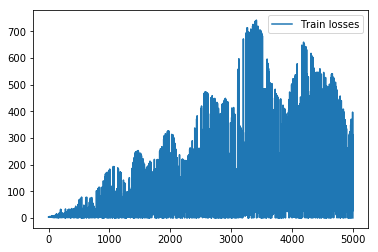

In [11]:
var_model = MLP_20(VocabSize,20)
optimizer = torch.optim.SGD(var_model.parameters(),lr=0.1)
loss_func = nn.CrossEntropyLoss()
model_100, losses_100 = train_5000(var_model,train_loader_newsgroups_tfidf,optimizer,loss_func,verbose=False)

In [9]:
#Variance
train_loader_newsgroups_tfidf,val_loader_newsgroups_tfidf = make_loaders(tfidf_train,train_labels,0.2,batch_size=100)

(9051, 51000) (9051,)
(2263, 51000) (2263,)


Iteration: 1 Loss: 2.995835065841675
Iteration: 501 Loss: 0.6259101033210754
Iteration: 1001 Loss: 0.8514846563339233
Iteration: 1501 Loss: 60.82896041870117
Iteration: 2001 Loss: 96.29426574707031
Iteration: 2501 Loss: 69.39492797851562
Iteration: 3001 Loss: 81.36959075927734
Iteration: 3501 Loss: 67.36750030517578
Iteration: 4001 Loss: 61.86973190307617
Iteration: 4501 Loss: 62.46577453613281


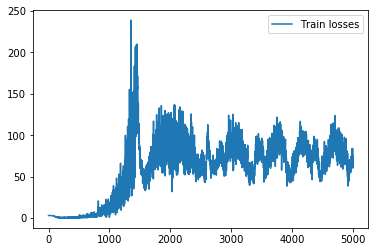

In [13]:
var_model = MLP_20(VocabSize,20)
optimizer = torch.optim.SGD(var_model.parameters(),lr=0.1)
loss_func = nn.CrossEntropyLoss()
model_100, losses_100 = train_5000(var_model,train_loader_newsgroups_tfidf,optimizer,loss_func,verbose=False)

##### 2.B.1

Given that the two models are the same, there is much more variance in the loss per iteration when using a minibatch size of 1. The variance of the loss when training one example at a time is high, because the loss is calculated on the performance of a single point. When the network performs well on a single example, the loss for that example is quite low, whereas when it performs poorly on a single example, the loss is quite high. This leads to high variance in loss from iteration to iteration.  When considering the loss on a larger mini-batch size, in this case 100, the loss for an iteration is averaged across 100 samples. In any given set of 100 samples, the model will likely perform well on some, and poorly on others, but overall from batch to batch, one would expect the loss to approach the loss on the whole dataset as the size of the minibatch is increased.

##### 2.B.2

In order to reduce the variance of loss during training, when using a minibatch size of 1, one could reduce the learning rate when training using a small batchsize. Reducing the learning rate will decrease the size of the step taken for a single example, and can, given enough time, be best for generalization. 

Intuitively, the step size for a single sample can be considered. Observe: 

(1/lr)\*batchsize = constant

By setting the constant for a specific batch size, one can modify the learning rate such that the total step taken for a single example is about the same. These smaller steps will reduce the change in parameters for each example, making the network's loss more stable, and reduce the variance in the loss as more samples are trained.